# Bootstrap Filter

In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

## Particle Filter
The particles are like datapoints

In [96]:
class BootstrapFilter(object):
    
    def __init__(self, d, likelihood=(0,0.5), prior=(-5,5), N=20, \
                 noise = 1., particles=None):
        self.dimension = d
        self.prior = prior
        self.noise = noise
        self.likelihood = likelihood
        if particles is not None:
            self.particles = particles
        else:           
            #particles are drawn form a uniform square
            self.particles = np.random.uniform(low=prior[0], high=prior[1],\
                                               size=(N,d))
        self.weights = np.ones(N)
        self.mean = []
        self.var = []
        
    def importantSampling(self, datum):
        a = self.particles.copy()
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(self.particles[i], \
                                               self.likelihood[1]).pdf(datum)        
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        mean = np.average(self.particles, weights=self.weights, axis=0)
        #self.mean.append(mean[0])
        #self.var.append(np.average((self.particles-self.mean[-1])**2,\
        #                           weights=self.weights, axis=0))        
        #TODO check for degeneracy
        return self.particles, self.weights
        
    def markovTransition(self, p):
        return p + np.random.normal(0,self.noise)
        
    def resample(self):
        #dont know yet
        pass
        

In [65]:
def printParticleFilter(data, particles, mean, weights=None):
    plt.plot(mean, color='g')
    plt.scatter(range(0,len(data)),data, color='red')
    alpha = 0.2
    for x, y in zip(range(len(data)), particles):
        plt.scatter([x] * len(y), y, color='g', alpha=alpha)
    plt.title('mean of the particle filter')
    plt.show()

In [98]:
def TestData(mean=[4,-4], var=[1,1], n=10, skips=1):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

def runParticleFilter():
    #create data
    data = TestData()
    particles = []
    weights = []
    #feed data to particle Filter
    bs = BootstrapFilter(1)
    for i, d in enumerate(data):
        p, w = bs.importantSampling(d)
        particles.append(p.copy())
        weights.append(w.copy())
    mean = bs.mean
    printParticleFilter(data, particles, mean)
    print weights[-1]
    print particles[-1]

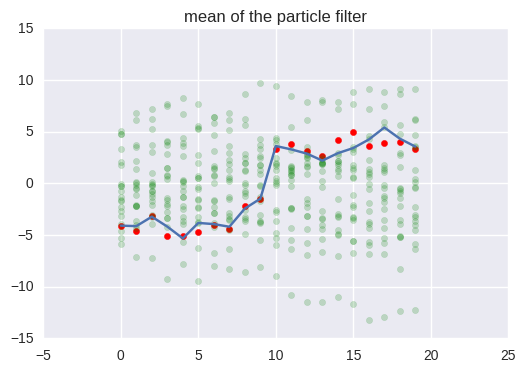

[  5.12965287e-008   3.56468379e-031   3.50494775e-038   1.20875451e-035
   7.33992170e-043   9.40535373e-074   8.96855516e-211   4.66123306e-001
   1.00545270e-008   6.60002152e-008   1.00178176e-002   1.96103383e-004
   4.98824016e-013   3.30724901e-028   2.25893177e-009   2.07286970e-012
   3.47973620e-047   6.95124855e-054   5.23662643e-001   2.80912010e-081]
[[  0.42011399]
 [  9.16647048]
 [ -3.27656249]
 [ -3.04945415]
 [ -3.67586644]
 [ -5.88505284]
 [-12.27274579]
 [  3.59429396]
 [  6.25772622]
 [  6.09594614]
 [  4.6924279 ]
 [  1.27100405]
 [ -0.45744082]
 [ -2.33106612]
 [  0.15814028]
 [ -0.36062376]
 [ -4.0254797 ]
 [ -4.53627805]
 [  3.4871497 ]
 [ -6.34660262]]


In [99]:
runParticleFilter()

## Particle Filter with discrete state and transition model

In [43]:
class BootstrapFilterDiscreteTransitionModel(object):
    
    def __init__(self, prior, tm, N=5000, noise = 0.1):

        self.tm = np.cumsum(tm, axis=1)
        
        #init particles
        #each particle has: state identifier, Mean, Var
        state = prior[0]
        n = N*state[-1]
        name = np.full((n), 0)
        mean = np.full((n), state[0])\
         + np.random.normal(scale=noise, size=n)
        var = np.full((n), state[1])\
         + np.random.normal(scale=noise, size=n)
        self.particles = np.stack((name,mean,var), axis=-1)
        
        for i, state in enumerate(prior[1:]):
            n = N*state[-1]
            name = np.full((n), i+1)
            mean = np.full((n), state[0])\
             + np.random.normal(scale=noise, size=n)
            var = np.full((n), state[1])\
             + np.random.normal(scale=noise, size=n)
            p = np.stack((name,mean,var), axis=-1)
            self.particles = np.concatenate((self.particles, p))
        print self.particles.shape
        
        
    def importantSampling(self, datum):
        
        for p in self.particles:
            self.markovTransition(p)
            #weightParticle
            #this needs to be saved in an array
            unWeightP = scipy.stats.norm(p[1], p[2]).pdf(datum)
        
        #normalise weights
        self.weights = normWeights(unWeights)
        
    def resample(self):
        #dont know yet
        pass
        
    def markovTransition(self, p):
        r = np.random.rand()
        newState = np.searchsorted(self.tm[p[0]], r)
        p[0] = newState
        #TODO update mean and var of particle to new state
        pass
        